# SFG DRO demo

In [1]:
from torch.optim.swa_utils import AveragedModel  # average model weights
import torch.optim as optim
import torch
from kdro.lsq_util import median_heuristic
from sgd.sfg_util import mnistData, buildModel, sfg_train_step, RKHSfunction, evalutateErmModel, pgd_linf, just_rand, plot_images_mnist

import matplotlib.pyplot as plt

In [2]:
# params
n_epoch_gd = 10 # how many epochs of SFG to run
learn_task = 'binary'
mini_batch = 20 
model_class = 'mlp'
loss_reduction = 'none'
n_rand_feat = 500
n_sample_zeta = 150
epsilon_attack = 0.5  # largest perturbation of the domain allowed in RO
epsilon = 1.0  # Kernel DRO ambiguity size
is_step_const = 0  # use decay step size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up
train_loader, test_loader = mnistData(task=learn_task, batch_size=mini_batch)
modelDecision, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device,
                                     loss_reduction=loss_reduction)
modelSWA = AveragedModel(modelDecision)  # model with averaged weights

# example test data
X_example = (test_loader.dataset.test_data.float() / 255).view(len(test_loader.dataset), -1)
y_example = test_loader.dataset.test_labels

# dual var f: RKHS function
_, kernel_gamma = median_heuristic(X_example, X_example)  # median heuristic
F = RKHSfunction(kernel_gamma * 2, n_feat=n_rand_feat)  # rkhs function using random features

# bookkeeping dict
stat_plot = {"max_cons_violation": [], "obj": []}

/Users/zplusj/anaconda3/envs/nipssub/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/zplusj/anaconda3/envs/nipssub/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/zplusj/anaconda3/envs/nipssub/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/Users/zplusj/anaconda3/envs/nipssub/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


# Training loop

In [3]:
print("=========Training SFG DRO=========")
i_decay_csa = 0  # counter for threshold decay
for i_epoch in range(n_epoch_gd):
    for i_batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        if learn_task == 'binary':
            y = y.float()

        i_decay_csa, stat_plot = sfg_train_step(X=X, y=y, just_rand=just_rand, loss_erm=loss_erm,
                                                modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                                                epsilon_attack=epsilon_attack,
                                                learn_task=learn_task, F=F, epsilon=epsilon, stat_plot=stat_plot,
                                                i_decay_csa=i_decay_csa,
                                                is_step_const=is_step_const,
                                                model_class=model_class, modelSWA=modelSWA)
    print('epoch:', i_epoch,'/',n_epoch_gd)
    
print("=========Training Finished=========")

=========Training SFG DRO=========
epoch: 0 / 10
epoch: 1 / 10
epoch: 2 / 10
epoch: 3 / 10
epoch: 4 / 10
epoch: 5 / 10
epoch: 6 / 10
epoch: 7 / 10
epoch: 8 / 10
epoch: 9 / 10
=========Training Finished=========


# Test trained model: predicting perturbed images

In [4]:
# load pretrained ERM model for comparison
loaded = torch.load('model_erm.pkl')
modelERM = loaded['model']

_, loss_erm= buildModel(task=learn_task, method='linear', n_hidden = 1, device=device) # create a simple loss to create an attack

# load some data
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    if learn_task=='binary':
        y=y.float()
    break
    
# create an attack
level_atk = 0.2
atk=pgd_linf

delta_final = atk(loss_erm, modelERM, X, y, level_atk, task=learn_task)

M, N = 2,9

## Plot clean image

<Figure size 432x288 with 0 Axes>

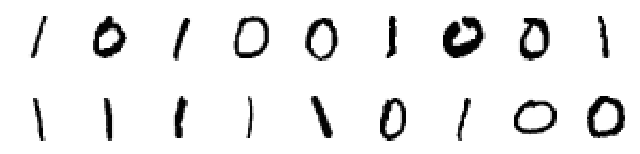

In [5]:
# plot training image
plt.figure()
f, ax = plt.subplots(M, N , sharex=True, sharey=True, figsize=(N, M * 1.3))

for i in range(M):
    for j in range(N):
        ax[i][j].imshow(1 - X[i * N + j][0].cpu().numpy(), cmap="gray")
        
        for label in ax[i][j].get_xticklabels():
            label.set_visible(False)
        for label in ax[i][j].get_yticklabels():
            label.set_visible(False)

        ax[i][j].axis('off')

plt.tight_layout()
plt.show()

## Prediction using model trained with KDRO

<Figure size 432x288 with 0 Axes>

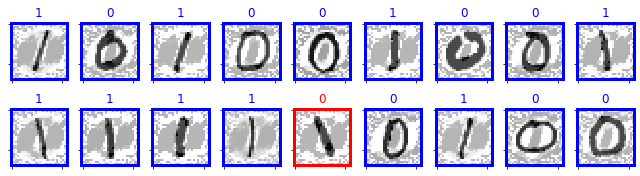

In [6]:
# plot trained model prediction
plt.figure()
yp = evalutateErmModel(modelSWA, X+delta_final, task=learn_task)
fig = plot_images_mnist(X + delta_final, y, yp,   M, N)

plt.tight_layout()
plt.show()

## Comparison: model trained with ERM

<Figure size 432x288 with 0 Axes>

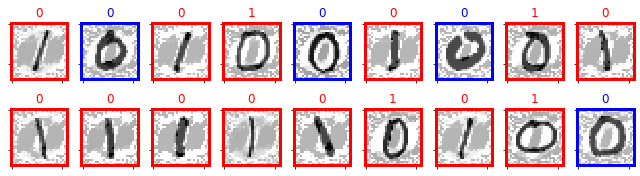

In [7]:
plt.figure()
yp = evalutateErmModel(modelERM, X+delta_final, task=learn_task)
fig = plot_images_mnist(X + delta_final, y, yp,   M, N)

plt.tight_layout()
plt.show()